In [1]:
import pandas
from pandas import DataFrame
import numpy
import matplotlib.pyplot as plt

Gọi Dữ liệu
--- 

In [3]:
#%run GETAPI.ipynb  #for calling data

Xử lý dữ liệu đọc thêm tại file [Data exploration](Q_Data_Exploration.ipynb)

Đọc dữ liệu
---

In [2]:
symbols = pandas.read_csv('Data/symbols.csv')
data = pandas.read_csv('Data/data.csv')
f_data = pandas.read_csv('Data/token_price.csv')

try:
    symbols = symbols.drop(['Unnamed: 0'], axis=1)
except:
    pass
try:
    data = data.drop(['Unnamed: 0'], axis=1)
except:
    pass
try:
    f_data = f_data.drop(['Unnamed: 0'], axis=1)
except:
    pass
base_coin = ['BUSD','USDT'] # đồng tiền ổn định giá

## Trả lời một sô câu hỏi

In [26]:
symbols[(symbols.symbol == 'BTCUSDT')|(symbols.symbol == 'ETHUSDT')][['baseAsset','quoteAsset']].unstack().nunique()

3

------

### Xem sự liên quan giữa giá và số lượng giao dịch

In [35]:
f_data[['base','Open price','High price','Low price','Close price','Number of trades']].groupby('base').mean().corr()

,Open price,High price,Low price,Close price,Number of trades
Open price,1.000000,1.000000,1.000000,1.000000,0.665169
High price,1.000000,1.000000,0.999999,1.000000,0.665176
Low price,1.000000,0.999999,1.000000,1.000000,0.665132
Close price,1.000000,1.000000,1.000000,1.000000,0.665142
Number of trades,0.665169,0.665176,0.665132,0.665142,1.000000


Độ tương quan khá thấp, nên có thể thấy số lượng giao dịch không có ảnh hưởng nhiều đến giá của đồng coin

---

### Kiểm tra xem giá trị quy đổi giữa các token với nhau, có tuân theo giá trị thực không

In [4]:
head_name = data.columns

In [5]:
def GetPrice(sym):
    for i in base_coin:
        temp = f_data[(f_data.base == sym) & (f_data.quote == i)]
        if temp.shape[0] !=0:
            return temp.set_index('Kline open time')[head_name[4:8]]
    return 1

In [6]:
temp = data.set_index(["Symbol","Kline open time"]).drop(head_name[8:],axis=1)
temp # xep lai data phan theo tung loại dao dich

base quote  Open price  High price  Low price  \
Symbol  Kline open time                                                  
ETHBTC  1669395600000     ETH   BTC    0.072026    0.072222   0.072026   
        1669397400000     ETH   BTC    0.072222    0.072335   0.072117   
        1669399200000     ETH   BTC    0.072163    0.072263   0.072101   
        1669401000000     ETH   BTC    0.072188    0.072261   0.072161   
        1669402800000     ETH   BTC    0.072223    0.072479   0.072197   
...                       ...   ...         ...         ...        ...   
BUSDRON 1670943600000    BUSD   RON    4.629000    4.630000   4.620000   
        1670945400000    BUSD   RON    4.620000    4.631000   4.620000   
        1670947200000    BUSD   RON    4.631000    4.631000   4.630000   
        1670949000000    BUSD   RON    4.630000    4.631000   4.630000   
        1670950800000    BUSD   RON    4.631000    4.631000   4.630000   

                         Close price  
Symbol  Kline open time               
ETHBTC  1669395600000       0.072222  
        1669397400000       0.072162  
        1669399200000       0.072189  
        1669401000000       0.072212  
        1669402800000       0.072375  
...                              ...  
BUSDRON 1670943600000       4.621000  
        1670945400000       4.630000  
        1670947200000       4.631000  
        1670949000000       4.631000  
        1670950800000       4.631000  

[1229162 rows x 6 columns]

In [43]:
diff = []
for i in set(temp.index.get_level_values(0)):
    baseA  =  symbols[symbols.symbol==i].baseAsset.values[0]
    quoteA = symbols[symbols.symbol==i].quoteAsset.values[0]
    cal = GetPrice(baseA) / GetPrice(quoteA)
    try:
        gap = numpy.nanmean(cal - temp.loc[i][head_name[4:8]],axis=0) #differenct between price
        # % of gap to total
        gap /= numpy.mean(temp.loc[i][head_name[4:8]],axis=0)
        diff += [gap]        
    except:
        diff += [[0,0,0,0]]
    pass

In [ ]:
numpy.mean(diff,axis = 0)

array([0.02731673, 0.02641888, 0.02802794, 0.02729723])

Sự chênh lệch nằm ở tầm 2-3% (dương) giá trị token, có thể nói khi trao đổi thông qua đồng tiền nền thì ta sẽ mất nhiều phí hơn là trao đổi trực tiếp giữa 2 token với nhau, nhưng đồng thời cũng cho thấy được là giá trị quy đổi các token có tuân theo giá trị thực của chúng

------

### Xem sét 1 đồng tiền cụ thể (ETH) để xem giao dịch có làm ảnh hưởng đến giá trị không

In [44]:
#tong so luong giao dich co lien quan den dong ETH theo thoi gian
ETH_price_trade =pandas.concat( [GetPrice('ETH'), data[(data.base == 'ETH' )|(data.quote == 'ETH')].groupby("Kline open time").sum()[["Number of trades"]]],axis = 1)
ETH_price_trade.corr()["Number of trades"]

Open price         -0.020199
High price          0.068455
Low price          -0.059944
Close price         0.017932
Number of trades    1.000000
Name: Number of trades, dtype: float64

Có thể thấy không có nhiều sự liên quan giữa số lượng giao dịch và giá đối với đồng tiền ETH này <br>
xem xét biểu đồ dưới đây

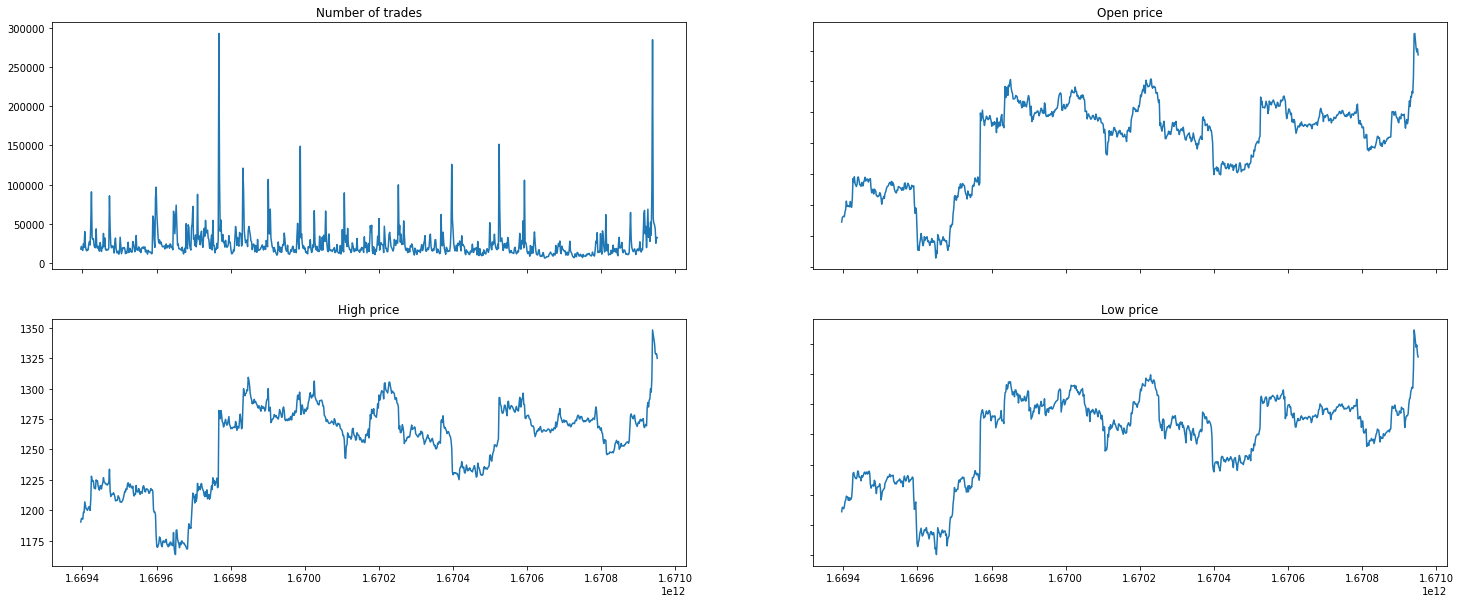

In [47]:
fig, axs = plt.subplots(2, 2,figsize=(25, 10))
axs[0, 0].plot(ETH_price_trade["Number of trades"])
axs[0, 0].set_title('Number of trades')
axs[0, 1].plot(ETH_price_trade["Open price"])
axs[0, 1].set_title('Open price')
axs[1, 0].plot(ETH_price_trade["High price"])
axs[1, 0].set_title('High price')
axs[1, 1].plot(ETH_price_trade["Low price"])
axs[1, 1].set_title('Low price')
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

Tuy nhiên, nếu chúng ta để ý thì tại những mốc có lượng giao dịch vượt trội (mode), thì giá của đồng ETH này cũng biến động lớn ở thời điểm gần như tương tự, thế nên số lương giao dịch, đôi khi cũng phải ảnh được các cột mốc quan trọng trong biến động giá của token
____

### câu 4

## Model

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers

In [4]:
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

Theo như một số câu hỏi trước thì có rất ít loại đồng có ảnh hưởng đến nhau, nên trong model này ta chỉ huấn luyện trên 1 đồng để nhận xet thử

In [5]:
model_set = data[data.Symbol == 'ETHBTC'].sort_values('Kline open time')[['Open price','High price','Low price','Close price']]

model_set = StandardScaler().fit_transform(model_set)

In [6]:
train_X, train_y = model_set, model_set[5:]
train_X.shape,train_y.shape

((865, 4), (860, 4))

In [7]:
model = keras.Sequential()
model.add(layers.LSTM(
    units = 128,
    input_shape =(5,4)
))
model.add(layers.Dense(units = 4))
model.compile(
    loss='mean_squared_error',
    optimizer=keras.optimizers.Adam(0.001)
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               68096     
                                                                 
 dense (Dense)               (None, 4)                 516       
                                                                 
Total params: 68,612
Trainable params: 68,612
Non-trainable params: 0
_________________________________________________________________


In [8]:
full_n = train_y.shape[0]
n  =  int(train_y.shape[0]*0.7)

In [9]:
ds = keras.preprocessing.timeseries_dataset_from_array(train_X[:n],train_y[:n],sequence_length=5,batch_size=1) #train
d2 = keras.preprocessing.timeseries_dataset_from_array(train_X[n:],train_y[n:],sequence_length=5,batch_size=1) #test

In [10]:
test_x = numpy.array([i[0] for i in d2])
test_x.resize(( full_n - n, 5, 4))

In [11]:
model.fit(ds)
y_pred = model.predict(test_x)
y_pred.shape

9/9 [==============================] - 1s 4ms/step


(258, 4)

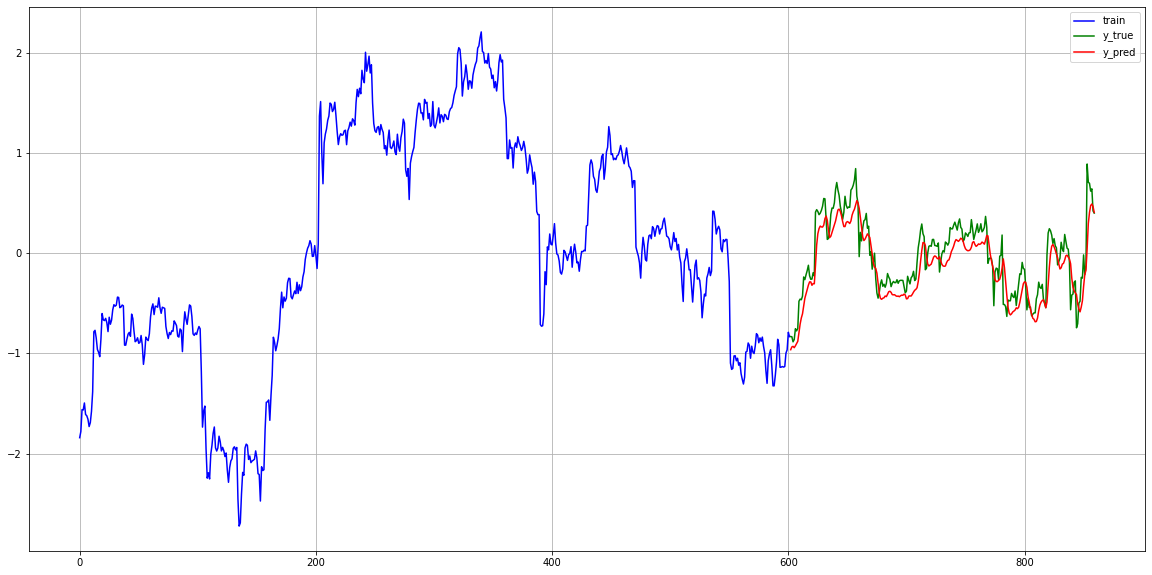

In [12]:
k = 2
plt.figure(figsize=(20, 10))
plt.grid(which='major', axis='both', zorder=-0.5)
plt.plot( np.array(train_y)[:n,k],'b',label = 'train')
plt.plot(range(n,full_n),np.array(train_y)[n:,k],'g',label = 'y_true')
plt.plot(range(n,full_n), y_pred[:,k],'r',label = 'y_pred')
plt.legend()

In [13]:
[sklearn.metrics.r2_score( np.array(train_y)[n:,i],y_pred[:,i]) for i in range(4)]

[0.7924152691699283,
 0.7049013098446117,
 0.7193705014228686,
 0.6558435684135733]

---

In [14]:
from sklearn.linear_model import LinearRegression


In [15]:
linear_model = LinearRegression()
linear_model.fit( [ np.array(i[0]).flatten() for i in ds], [ np.array(i[1]).flatten() for i in ds] )

LinearRegression()

In [16]:
y_pred  = linear_model.predict( [ np.array(i[0]).flatten() for i in d2])
y_true = np.array([np.array(i[1]).flatten() for i in d2])

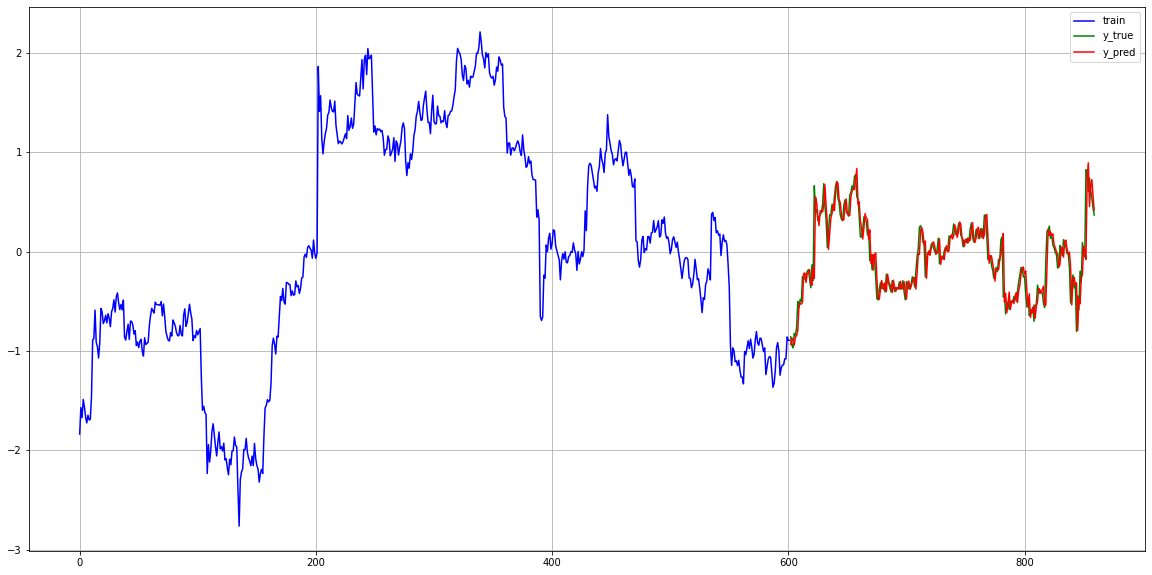

In [17]:
k = 3
plt.figure(figsize=(20, 10))
plt.grid(which='major', axis='both', zorder=-0.5)
plt.plot( np.array(train_y)[:n,k],'b',label = 'train')
plt.plot(range(n,full_n),(y_true)[:,k],'g',label = 'y_true')
plt.plot(range(n,full_n), y_pred[:,k],'r',label = 'y_pred')
plt.legend()

In [18]:
[sklearn.metrics.r2_score( np.array(y_true)[:,i],y_pred[:,i]) for i in range(4)]

[0.9999436927999247, 0.8741147075253277, 0.908063666323902, 0.8282259142106378]

In [89]:
def r2_score_linear(symbol:str,plot = True,k=3,scaler = StandardScaler):
    set = data[data.Symbol == symbol].sort_values('Kline open time')[['Open price','High price','Low price','Close price']]
    if scaler != None:
        set = scaler().fit_transform(set)

    X, y = set, set[5:]

    _full_n = y.shape[0]
    _n  = int(y.shape[0]*0.7)

    d_s1 = keras.preprocessing.timeseries_dataset_from_array(X[:_n],y[:_n],sequence_length=5,batch_size=1) #train
    d_s2 = keras.preprocessing.timeseries_dataset_from_array(X[_n:],y[_n:],sequence_length=5,batch_size=1) #test

    linear_ = LinearRegression()
    linear_.fit( [ np.array(i[0]).flatten() for i in d_s1], [ np.array(i[1]).flatten() for i in d_s1] )
    _pred  = linear_.predict( [ np.array(i[0]).flatten() for i in d_s2])
    _true = np.array([np.array(i[1]).flatten() for i in d_s2])

    if plot:
        plt.figure(figsize=(20, 10))
        plt.grid(which='major', axis='both', zorder=-1.0)
        plt.plot( np.array(y)[:_n,k],'b',label = 'train')
        plt.plot(range(_n,_full_n),(_true)[:,k],'g',label = 'y_true')
        plt.plot(range(_n,_full_n), _pred[:,k],'r',label = 'y_pred')
        plt.legend()

    print( np.mean(_pred - _true ,axis = 0) )
    return np.array([sklearn.metrics.r2_score( _true[:,i],_pred[:,i]) for i in range(4)])

[-0.0001566  -0.0085964  -0.01872118 -0.02213848]


array([0.99998555, 0.95153192, 0.98227653, 0.94915843])

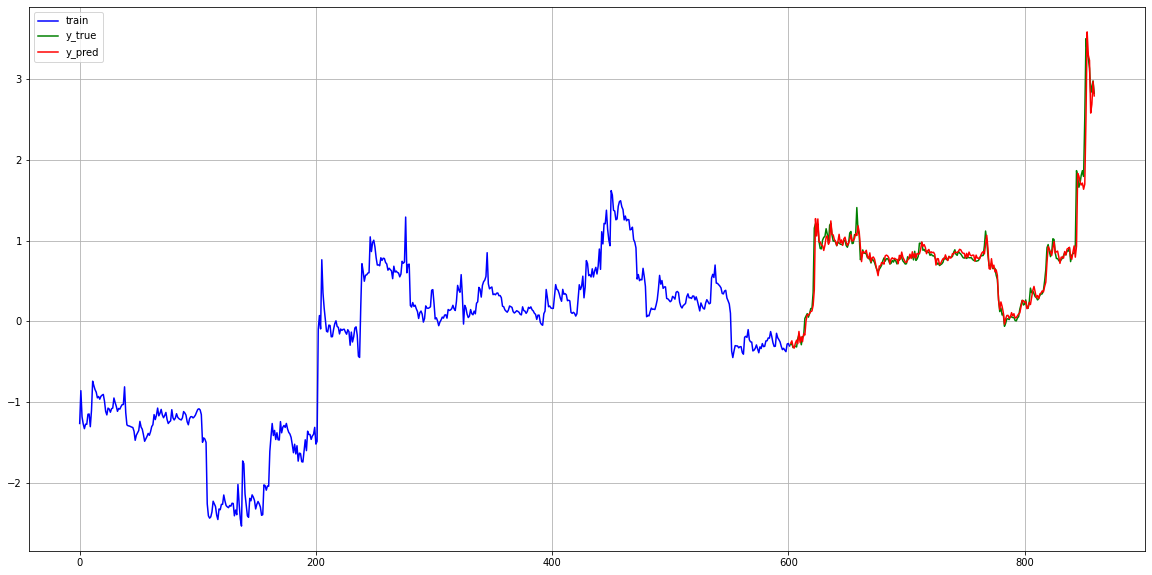

In [90]:
r2_score_linear('BTCUSDT',k=1)

Kết qua mô hình dự đoán với chỉ số khá cao, tuy nhiên việc áp dụng thực tế thì không hẳn là được, do dự đoán này sẽ phải dựa vào 5 mốc tgian trước đó, không phải hoàn toàn là sinh ra từ mô hình, nên việc giá có thể lên đỉnh, hoặc xuống đáy trong thời gian sau thì không được chắc chắn